In [1]:
import os
os.chdir('/home/david/Projects/optogenetic_whole_cell_activation/morph_impact_on_opt_stim')
import numpy as np
import pandas as pd
from neuron import h
from neurostim.cell import Cell
from neurostim.light_classes import LightSource, LightStimulation
from neurostim.utils import convert_polar_to_cartesian_xz, interpolate
from neurostim.polarmaps import get_AP_times, simple_polar_map
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

def step_round(a, step):
    return np.round(np.array(a, dtype=float) / step) * step

In [2]:
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

In [3]:
# simulate conductances in L5 cell for selected light powers
hoc_file = 'L5'
plot_path = 'paper/NEW_FIGURES/FIG3/plots/'+hoc_file+'_'

#light_powers = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
light_powers = [1e-4, 1e-3, 5e-3]
#light_powers = [5e-5,3e-4, 2e-2]

In [4]:
# model config 1 ---- *** DO NOT RERUN ***
# NEURON simulator setup is corrupted if reinitialized in a running kernel, rerun complete notebook

# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um

# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9

# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/" + str(hoc_file) + ".hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=chanrhod_soma_density,
    ChR_distribution=str(chanrhod_distribution)
)

	1 
	1 
	1 
	1 


In [5]:
# model config 2 (can be adapted and rerun without restarting notebook kernel)

# light source model and params
light_model = 'foutz_et_al2012'
fiber_diameter = 200 #um
fiber_NA = 0.22
# stimulation duration
light_duration = 200 # ms
# other params
light_delay = 1 #ms
tot_rec_time = light_delay + light_duration + 10
AP_threshold = 0 # mV
interpol_dt = 0.1 # ms

def setup_stimulation(radius, angle, light_power, 
                      light_delay=light_delay, light_duration=light_duration, light_model=light_model, 
                      fiber_diameter=fiber_diameter, fiber_NA=fiber_NA, cell=cell): 
    # light source initialization
    light_x, light_y = convert_polar_to_cartesian_xz(radius, angle)
    light_z = 0  # cortical surface
    light_pos = (light_x, light_y, light_z)
    light_source = LightSource(
        model=str(light_model),
        position=(light_x, light_y, light_z),
        width=float(fiber_diameter),
        NA=float(fiber_NA)
    )
    # stimulation object initialization
    light_stim = LightStimulation(
        cell=cell,
        light_source=light_source,
        delay=float(light_delay),
        duration=float(light_duration),
        light_power=float(light_power),
        record_all_segments=False,
    )
    return light_source, light_stim

def stimulate_and_measure(radius, angle, light_power, rec_vars):
    # initialize light source and stim with standard params
    light_source, light_stim = setup_stimulation(radius, angle, light_power)
    # simulate
    measurement = pd.DataFrame(
        light_stim.simulate_and_measure(
            tot_rec_time=float(tot_rec_time),
            extra_rec_var_names=rec_vars[0],
            extra_rec_var_pointers=[eval(item) for item in rec_vars[1]],
        )
    )
    # dealing with drop full row duplicates
    # drop completely redundant duplicates
    measurement = measurement.drop_duplicates()
    # add 1e-12 ms to 2nd entry time point of duplicate entries with the same time but different (e.g. Vm) values
    measurement.loc[measurement["time [ms]"].diff() == 0, "time [ms]"] += 1e-12
    # interpolate simulation results
    measurement = interpolate(
        df=measurement, interpolation_dt=float(interpol_dt)
    )
    return measurement

# define measurement variables
segs = [seg for sec in h.allsec() for seg in sec][:-1] # exclude last seg as it is the light source
segcatpointernames = [str(seg) for seg in segs]
segcatpointers = ['h.'+str(seg)+'._ref_gcat_chanrhod' for seg in segs]

radii = [0,100,200,300,400,500]
angles = [0,np.pi/2,np.pi,np.pi*3/2]

res = []
for light_power in light_powers:
    print("simulated 1 lp step")
    for radius in radii:
        for angle in angles:
            measurement = stimulate_and_measure(radius, angle, light_power, rec_vars=[segcatpointernames,segcatpointers])
            # convert density conductance into real conductance for each segment
            for seg, seg_gcat in zip(segs, segcatpointernames):
                measurement[seg_gcat] *= eval('h.'+str(seg)+'.area()') * 1e-8 # eval area of segment and convert from um2 to cm2
            t_sec_g = pd.melt(measurement, id_vars=['time [ms]'], value_vars=segcatpointernames).set_index(['variable', 'time [ms]'])
            total_sec_g = t_sec_g.groupby('variable').sum()
            #total_sec_g['g_normalized'] = total_sec_g / total_sec_g.sum()
            total_sec_g['light_power'] = light_power
            total_sec_g['radius']=radius
            total_sec_g['angle']=angle
            total_sec_g['APC'] = len(get_AP_times(measurement, interpol_dt=0.1, AP_threshold=0, t_on=light_delay))
            res.append(total_sec_g)
total_sec_g = pd.concat(res)
total_sec_g = total_sec_g.reset_index()
#total_sec_g['r_xy']= np.sqrt(np.array([eval('h.'+seg+'.x_chanrhod') for seg in total_sec_g.variable])**2 + np.array([eval('h.'+seg+'.y_chanrhod') for seg in total_sec_g.variable])**2)
#total_sec_g['z'] = [eval('h.'+seg+'.z_chanrhod') for seg in total_sec_g.variable]
#total_sec_g['g_normalized_times_z'] = total_sec_g.g_normalized * total_sec_g.z
#total_sec_g['g_normalized_times_r_xy'] = total_sec_g.g_normalized * total_sec_g.r_xy

simulated 1 lp step
simulated 1 lp step
simulated 1 lp step


In [6]:
t_sec_g['value'].sum()

1.7910873980518686e-06

In [7]:
total_sec_g.set_index(['light_power', 'radius', 'angle']).loc[0.005,500,angles[-1]].sum()

variable    ais[0](0.05)ais[0](0.15)ais[0](0.25)ais[0](0.3...
value                                             1.79109e-06
APC                                                       835
dtype: object

In [8]:
#total_sec_g_cp = total_sec_g.copy()

In [9]:
#total_sec_g.columns

In [10]:
#total_sec_g = total_sec_g[['variable', 'value', 'light_power', 'radius', 'angle']]

In [11]:
total_sec_g

,variable,value,light_power,radius,angle,APC
0,ais[0](0.05),1.368314e-10,0.0001,0,0.000000,4
1,ais[0](0.15),1.352569e-10,0.0001,0,0.000000,4
2,ais[0](0.25),1.334704e-10,0.0001,0,0.000000,4
3,ais[0](0.35),1.316880e-10,0.0001,0,0.000000,4
4,ais[0](0.45),1.299100e-10,0.0001,0,0.000000,4
...,...,...,...,...,...,...
60115,soma(0.55),1.384140e-09,0.0050,500,4.712389,1
60116,soma(0.65),1.419125e-09,0.0050,500,4.712389,1
60117,soma(0.75),1.432909e-09,0.0050,500,4.712389,1
60118,soma(0.85),1.211227e-09,0.0050,500,4.712389,1


(15, 32) (15, 32) (15, 32)
91.57878710911916 577.6989644790528


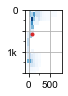

(15, 32) (15, 32) (15, 32)
81.25618614344533 728.0845268415218


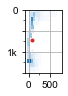

(15, 32) (15, 32) (15, 32)
75.539887062969 869.128760370975


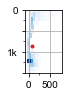

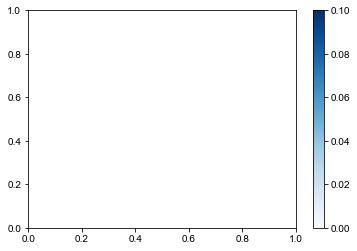

0.09393341336714603

In [12]:
def plot_conductance_map(total_sec_g, vmin, vmax,figsize, normalize_total_conductance=False, r_segmentation=100, z_segmentation=100, mirror_neuron=False):
    # colormap of conductance strength according to their position in the morphology (projected on the radial axis)
    sec_lp_rad_g_mean = pd.DataFrame(total_sec_g.groupby(['variable','light_power']).value.mean()).reset_index()
    sec_lp_rad_g_mean['r_xy'] = np.sqrt(np.array([eval('h.'+seg+'.x_chanrhod') for seg in sec_lp_rad_g_mean.variable])**2 + np.array([eval('h.'+seg+'.y_chanrhod') for seg in sec_lp_rad_g_mean.variable])**2)
    sec_lp_rad_g_mean['z'] = [eval('h.'+seg+'.z_chanrhod') for seg in sec_lp_rad_g_mean.variable]
    # round to step
    step = 100
    sec_lp_rad_g_mean['r_xy_round'] = sec_lp_rad_g_mean.r_xy.apply(lambda x: step_round(x, r_segmentation))
    sec_lp_rad_g_mean['z_round'] = sec_lp_rad_g_mean.z.apply(lambda x: step_round(x, z_segmentation))
    # sum over all r and z with the same value
    sec_lp_rad_g_mean = pd.DataFrame(sec_lp_rad_g_mean.groupby(["light_power","r_xy_round","z_round"])["value"].sum()).reset_index()
    rs = np.arange(0,700+r_segmentation,r_segmentation)
    zs = np.arange(-3100,0+z_segmentation,z_segmentation)
    rr, zz = np.meshgrid(rs, zs, indexing='ij')
    pivots = []
    for lp in light_powers:
        pivots.append(
            sec_lp_rad_g_mean.loc[sec_lp_rad_g_mean.light_power==lp].merge(
                pd.DataFrame(data=np.array([rr.flatten(),zz.flatten()]).T, columns=['r_xy_round','z_round']), how='outer').sort_values(
                by=['r_xy_round','z_round']).pivot("r_xy_round","z_round","value")
        )
    for i, lp in enumerate(light_powers):
        fig, ax = plt.subplots(figsize=figsize)
        if normalize_total_conductance:
            print(rr.shape, zz.shape, pivots[i].shape)
            pivots[i] /= np.nansum(pivots[i])
            if mirror_neuron:
                xx2 = np.append(rr[::-1]*-1,rr,axis=0)
                zz2 = np.append(zz,zz, axis=0)
                b = np.append(pivots[i].values[::-1],pivots[i].values,axis=0)
                print(xx2.shape, zz2.shape, b.shape)
            else:
                xx2=rr
                zz2=zz
                b=pivots[i]
            mappable = ax.pcolormesh(xx2,zz2,b, shading='nearest', cmap='Blues', vmin=vmin, vmax=vmax)
            #ax.set_xlim(-750,750)
        else:
            mappable = ax.pcolormesh(rr,zz,pivots[i], cmap='jet', norm=LogNorm(vmin=vmin, vmax=vmax))
            #ax.set_xlim(0,700)
        # radial distance of conductance
        r_cond = [np.sum(np.nansum(pivot.values,axis=1)/np.sum(np.nansum(pivot.values,axis=1))*np.arange(0,700+r_seg,r_seg)) for i, pivot in enumerate(pivots)][i]
        # depth
        z_cond = [np.sum(np.nansum(pivot.values,axis=0)/np.sum(np.nansum(pivot.values,axis=1))*np.arange(3100,-z_seg,-z_seg)) for i, pivot in enumerate(pivots)][i]
        ax.plot([r_cond], [-z_cond], marker='.',color='tab:red', linestyle='', zorder=10)
        print(r_cond,z_cond)
        ax.axis('equal')
        ax.set_ylim(-1500,0)
        ax.set_yticks([-1500,-1000,-500,0])
        ax.set_yticklabels(['','1k','','0'])
        ax.set_yticks([-250,-750,-1250], minor=True)
        ax.grid()
        #ax.legend()
        #ax.plot(
        #ax.set_yticklabels([])
        if mirror_neuron:
            ax.set_xticks([-500,0,500])
            ax.set_xticklabels(['','0','500'])
            ax.set_xticks([-250,250], minor=True)
        else:
            ax.set_xticks([0,500])
            ax.set_xticklabels(['0','500'])
            ax.set_xticks([250], minor=True)
        fig.savefig(plot_path+"conductance_morphology_"+str(lp)+".png", dpi=dpi, 
                    facecolor='w', edgecolor='w',  
                    bbox_inches='tight')
        plt.show()
    #fig.suptitle("conductances throughout morpology averaged over all light source positions. Light powers: "+str(light_powers))
    #plt.colorbar(mappable, label='summed conductance')
    return fig, ax, mappable, pivots
#fig, ax, mappable, pivots = plot_conductance_map(total_sec_g, vmin=1e-11, vmax=1e-5, r_segmentation=10, z_segmentation=100)
#plt.colorbar(mappable)
#plt.show()
r_seg = 50
z_seg = 100
fig2, ax2, mappable2, pivots2 = plot_conductance_map(total_sec_g, vmin=0, vmax=0.1, r_segmentation=r_seg, z_segmentation=z_seg, normalize_total_conductance=True,figsize=(pw/10,pw/5.7))
plt.colorbar(mappable2)
plt.show()
np.nanmax(pivots2[0].values)

In [13]:
pivots2[0].shape

(15, 32)

### conductance inside the L5 neuron morphology projected onto the radial-depth-plane, integrated over simulation time, averaged over light source positions for different light powers (rows) 

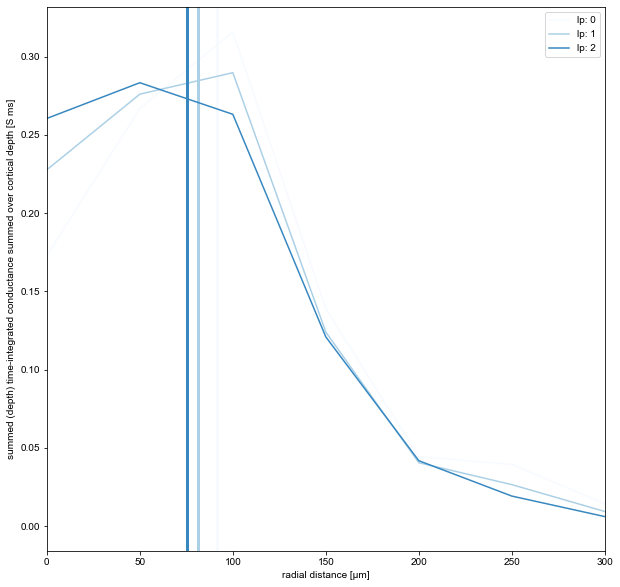

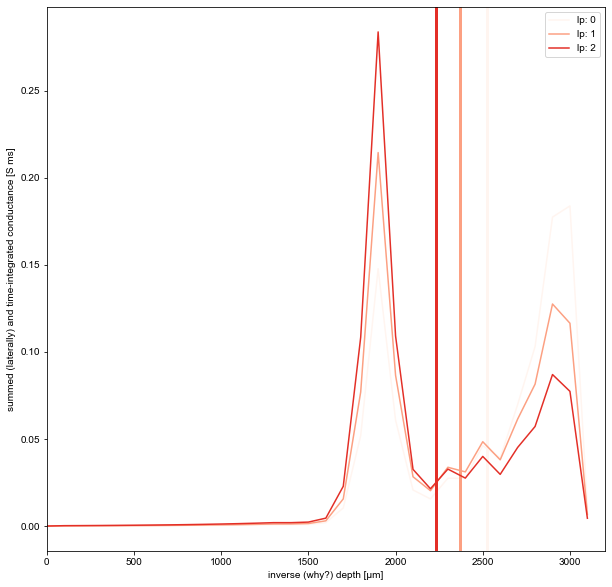

In [14]:
# for i, pivot in enumerate(pivots):
#     plt.plot(np.arange(0,3200,100),np.nansum(pivots[i].values,axis=0))
#     plt.xlim(0,3200)
#     plt.title('lp: '+str(i))
#     plt.show()
from matplotlib.cm import Blues as cmap
plt.figure(figsize=(10,10))
for i, pivot in enumerate(pivots2):
    color = cmap(i/len(pivots2))
    tmp = plt.plot(np.arange(0,700+r_seg,r_seg),np.nansum(pivot.values,axis=1), label='lp: '+str(i), color=color)
    plt.axvline(x=np.sum(np.nansum(pivot.values,axis=1)/np.sum(np.nansum(pivot.values,axis=1))*np.arange(0,700+r_seg,r_seg)),color=tmp[0].get_color(),lw=3)
    #print(np.nansum(pivot.values,axis=1).mean())
    plt.xlim(0,300)
plt.legend()
plt.xlabel("radial distance [µm]")
plt.ylabel("summed (depth) time-integrated conductance summed over cortical depth [S ms]")
plt.show()
from matplotlib.cm import Reds as cmap
plt.figure(figsize=(10,10))
for i, pivot in enumerate(pivots2):
    color = cmap(i/len(pivots2))
    tmp = plt.plot(np.arange(0,3100+z_seg,z_seg),np.nansum(pivot.values,axis=0), label='lp: '+str(i), color=color)
    plt.axvline(x=np.sum(np.nansum(pivot.values,axis=0)/np.sum(np.nansum(pivot.values,axis=1))*np.arange(0,3100+z_seg,100)),color=tmp[0].get_color(),lw=3)
    #print(np.nansum(pivot.values,axis=1).mean())
    plt.xlim(0,3200)
plt.xlabel("inverse (why?) depth [µm]")
plt.ylabel("summed (laterally) and time-integrated conductance [S ms]")
plt.legend()
plt.show()

### for high light powers, the mean location of conductance moves to lower radial offset and deeper into the cortex 

(900.0, 0.0)

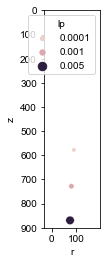

In [15]:
# radial distance of conductance
r_cond = [np.sum(np.nansum(pivot.values,axis=1)/np.sum(np.nansum(pivot.values,axis=1))*np.arange(0,700+r_seg,r_seg)) for i, pivot in enumerate(pivots2)]
# depth
z_cond = [np.sum(np.nansum(pivot.values,axis=0)/np.sum(np.nansum(pivot.values,axis=1))*np.arange(3100,-z_seg,-z_seg)) for i, pivot in enumerate(pivots2)]

import seaborn as sns
fig = plt.figure(figsize=(1,4))
sns.scatterplot(data = pd.DataFrame(data=np.array([r_cond, z_cond, light_powers]).T, columns=['r','z','lp']),
                x='r', y='z',
                hue='lp', size='lp')
plt.axis('equal')
plt.ylim(900,0)

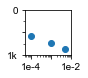

In [16]:
fig, ax = plt.subplots(figsize=(pw/8,pw/8))
ax.plot(light_powers, z_cond, marker='o', linestyle='')
ax.set_yticks([1000,500,0])
ax.set_yticklabels(['1k','','0'])
ax.set_yticks([750,250], minor=True)
ax.set_ylim(1000,0)

ax.set_xscale('log')
ax.set_xlim(5e-5,1e-2)
ax.set_xticks([1e-4,1e-3,1e-2])
ax.set_xticklabels(['1e-4','','1e-2'])
fig.savefig(plot_path+'_conductance_line.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

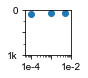

In [17]:
fig, ax = plt.subplots(figsize=(pw/8,pw/8))
ax.plot(light_powers, r_cond, marker='o', linestyle='')
ax.set_yticks([1000,500,0])
ax.set_yticklabels(['1k','','0'])
ax.set_yticks([750,250], minor=True)
ax.set_ylim(1000,0)

ax.set_xscale('log')
ax.set_xlim(5e-5,1e-2)
ax.set_xticks([1e-4,1e-3,1e-2])
ax.set_xticklabels(['1e-4','','1e-2'])
fig.savefig(plot_path+'_conductance_line.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

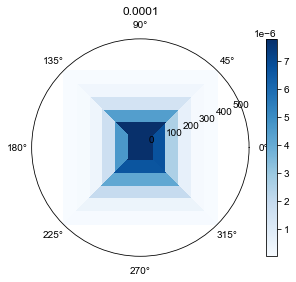

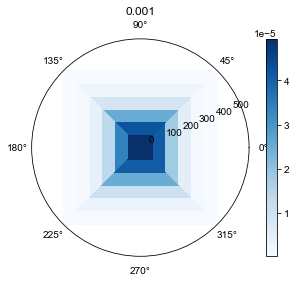

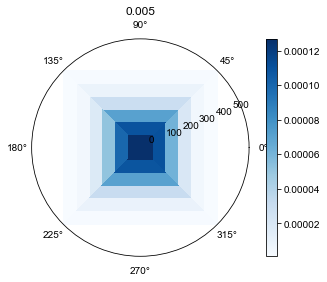

In [18]:
# spatial conductance profiles (light source location mapped)
total_g_light_source_loc_mapped = pd.DataFrame(total_sec_g.groupby(['light_power','radius','angle']).value.sum()).reset_index().rename(columns={'radius': 'radius [um]', 'angle': 'angle [rad]'}).set_index(['light_power','radius [um]','angle [rad]'])
import matplotlib as mpl
import copy
from neurostim.polarmaps import simple_polar_map
for lp in light_powers:
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax, mappable = simple_polar_map(
            data=total_g_light_source_loc_mapped.loc[lp].reset_index(),
            plot_col='value',
            cmap=copy.copy(mpl.cm.get_cmap("Blues")),
            ax=ax,
            vmin=None,
            vmax=None)
    plt.colorbar(mappable)
    plt.title(str(lp))
    plt.show()

In [19]:
h.soma(0.5).area()

183.85635262132297

In [20]:
# calculate light energy absorbed by cell 
light_energy_df = []
light_energy_per_compartment = []
for light_power in light_powers:
    for radius in np.arange(0,1000,25):
        for angle in np.arange(0,2*np.pi,np.pi/8):
            light_source, light_stim = setup_stimulation(radius, angle, light_power)
            segs, Txs = light_stim.get_segs_Txs()
            light_energy = 0
            for seg, Tx in zip(segs, Txs):
                tmp2 = dict()
                tmp2['light_energy'] = seg.area() * Tx * light_power
                tmp2['light_power'] = light_power
                tmp2['radius'] = radius
                tmp2['angle']=angle
                tmp2['seg']=str(seg)
                light_energy_per_compartment.append(tmp2)
                light_energy += seg.area() * Tx * light_power
            tmp=dict()
            tmp['light_power'] = light_power
            tmp['radius'] = radius
            tmp['angle']=angle
            tmp['light_energy']=light_energy
            light_energy_df.append(tmp)
light_energy_df = pd.DataFrame(light_energy_df)
light_energy_per_compartment = pd.DataFrame(light_energy_per_compartment)

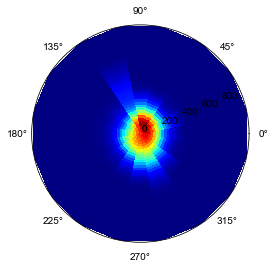

In [21]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax, mappable = simple_polar_map(
        data=light_energy_df.set_index(['light_power']).loc[light_powers[0]].reset_index().rename(columns=dict(radius='radius [um]', angle='angle [rad]')),
        plot_col='light_energy',
        cmap=copy.copy(mpl.cm.get_cmap("jet")),
        ax=ax,
        vmin=None,
        vmax=None)
#plt.colorbar(mappable)
#plt.savefig('paper/NEW_FIGURES/FIG2/plots/tmp_le_abs.png',dpi=300)
plt.show()

In [22]:
total_g_light_source_loc_mapped

value
light_power radius [um] angle [rad]              
0.0001      0           0.000000     7.772693e-06
                        1.570796     7.772693e-06
                        3.141593     7.772693e-06
                        4.712389     7.772693e-06
            100         0.000000     6.765129e-06
...                                           ...
0.0050      400         4.712389     9.607407e-06
            500         0.000000     9.147212e-07
                        1.570796     1.652311e-06
                        3.141593     8.425973e-07
                        4.712389     1.791087e-06

[72 rows x 1 columns]

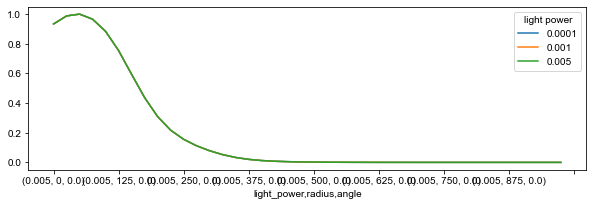

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

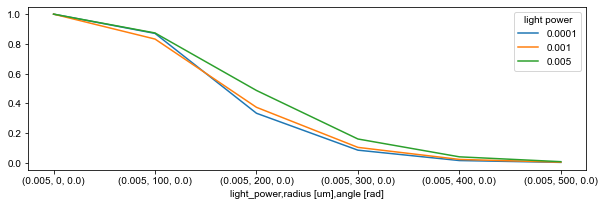

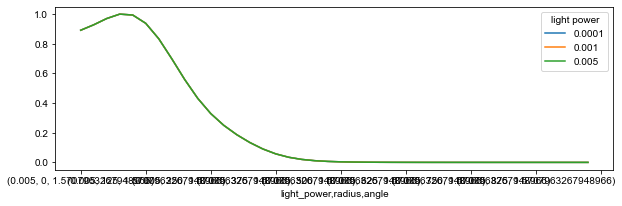

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

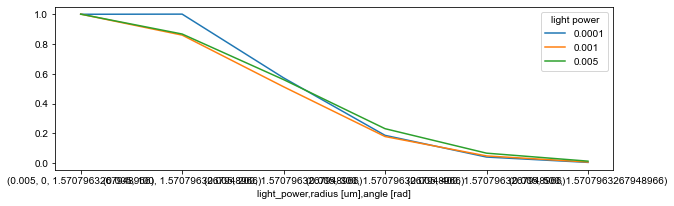

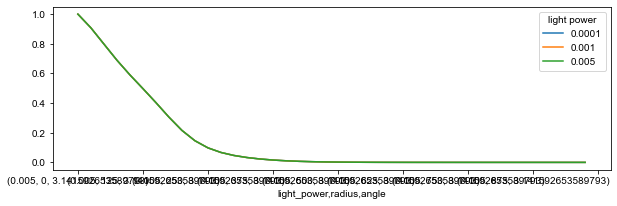

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

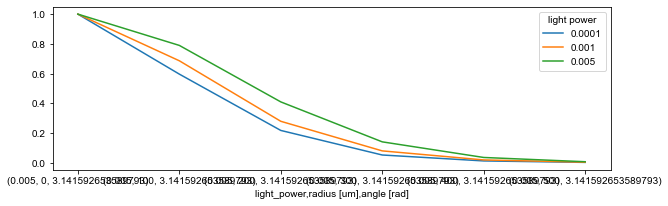

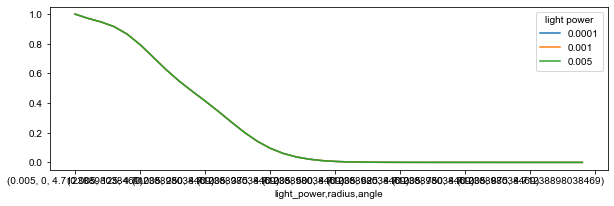

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

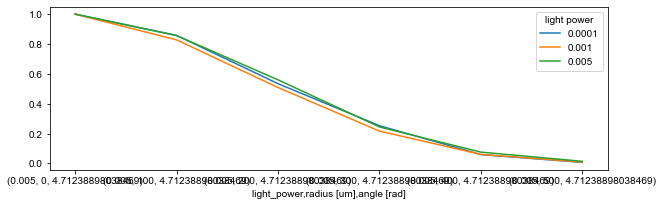

In [23]:

for angle in np.arange(0,2*np.pi,np.pi/2):
    plt.figure(figsize=(10,3))
    for lp in light_powers:
        #dfplot = pd.DataFrame(light_energy_df.groupby(['light_power', 'radius'])['light_energy'].mean()).loc[lp]
        dfplot = light_energy_df.set_index(['light_power','radius','angle']).loc[lp,:,angle]
        dfplot['normalized']=dfplot['light_energy']/dfplot['light_energy'].max()
        dfplot['normalized'].plot(label=str(lp))
    plt.legend(title='light power')
    plt.show()
    plt.figure(figsize=(10,3))
    for lp in light_powers:
        #dfplot = pd.DataFrame(total_g_light_source_loc_mapped.groupby(['light_power', 'radius [um]'])['value'].mean()).loc[lp]
        dfplot = total_g_light_source_loc_mapped.loc[lp,:,angle]
        dfplot['normalized']=dfplot['value']/dfplot['value'].max()
        dfplot['normalized'].plot(label=str(lp))
    plt.legend(title='light power')
    plt.show()


In [24]:
h.soma(0.5).z_chanrhod

-1186.5

In [25]:
cond_light_energy_merged = total_sec_g.rename(columns=dict(variable='seg', value='conductance')).merge(light_energy_per_compartment)
c_le_stimpositionavrg = cond_light_energy_merged.groupby(['light_power', 'seg'])['conductance', 'light_energy','APC'].mean()
c_le_stimpositionavrg['depth'] = [ eval('h.'+seg+'.z_chanrhod') for seg in c_le_stimpositionavrg.reset_index().seg]
c_le_stimpositionavrg['conductance_dens'] = [ cond/eval('h.'+seg+'.area()') for seg, cond in zip(c_le_stimpositionavrg.reset_index().seg, c_le_stimpositionavrg.conductance)]
c_le_stimpositionavrg['light_intensity'] = [ le/eval('h.'+seg+'.area()') for seg, le in zip(c_le_stimpositionavrg.reset_index().seg, c_le_stimpositionavrg.light_energy)]
def compartment_converter(seg):
    if 'ais' in str(seg):
        return 'axon'
    elif 'soma' in str(seg):
        return 'soma/basal'
    elif 'dend11' in str(seg):
        if eval('h.'+str(seg)+'.z_chanrhod') < -300:
            return 'apical shaft'
        else:
            return 'apical'
    elif 'dend' in str(seg):
        return 'soma/basal'
    elif 'myelin' in str(seg):
        return 'axon'
    elif 'nakeaxon' in str(seg):
        return 'axon'
    elif 'node' in str(seg):
        return 'axon'
    elif 'hill' in str(seg):
        return 'axon'
    else:
        return 'None'
c_le_stimpositionavrg['seglabel'] = [compartment_converter(seg) for seg in c_le_stimpositionavrg.reset_index().seg]
c_le_stimpositionavrg

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


conductance  light_energy        APC    depth  \
light_power seg                                                            
0.0001      ais[0](0.05)  5.366888e-11      0.004486   3.041667 -1210.25   
            ais[0](0.15)  5.306254e-11      0.004435   3.041667 -1210.75   
            ais[0](0.25)  5.237270e-11      0.004378   3.041667 -1211.25   
            ais[0](0.35)  5.168423e-11      0.004320   3.041667 -1211.75   
            ais[0](0.45)  5.099715e-11      0.004262   3.041667 -1212.25   
...                                ...           ...        ...      ...   
0.0050      soma(0.55)    1.271373e-07     16.355513  11.333333 -1186.50   
            soma(0.65)    1.283273e-07     16.465351  11.333333 -1189.50   
            soma(0.75)    1.275729e-07     16.325892  11.333333 -1192.50   
            soma(0.85)    1.061798e-07     13.552933  11.333333 -1195.50   
            soma(0.95)    6.433617e-08      8.190775  11.333333 -1198.50   

                          conductance_dens  light_intensity    seglabel  
light_power seg                                                          
0.0001      ais[0](0.05)      2.024489e-11         0.001692        axon  
            ais[0](0.15)      2.022390e-11         0.001690        axon  
            ais[0](0.25)      2.020293e-11         0.001689        axon  
            ais[0](0.35)      2.018198e-11         0.001687        axon  
            ais[0](0.45)      2.016106e-11         0.001685        axon  
...                                    ...              ...         ...  
0.0050      soma(0.55)        6.915033e-10         0.088958  soma/basal  
            soma(0.65)        6.889310e-10         0.088395  soma/basal  
            soma(0.75)        6.863627e-10         0.087836  soma/basal  
            soma(0.85)        6.837984e-10         0.087281  soma/basal  
            soma(0.95)        6.812382e-10         0.086730  soma/basal  

[2505 rows x 7 columns]

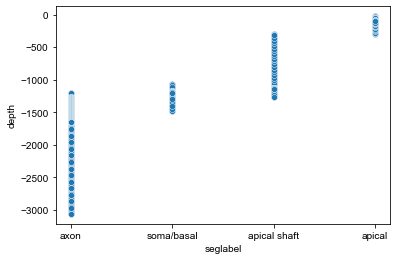

In [26]:
#verify seglabels:
sns.scatterplot(data=c_le_stimpositionavrg, x='seglabel', y='depth')
plt.show()

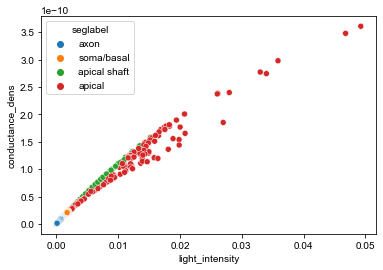

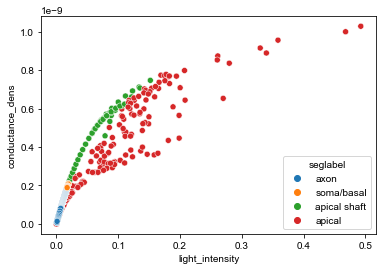

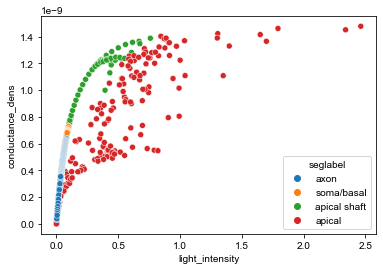

In [27]:
for lp in light_powers:
    sns.scatterplot(
        data=c_le_stimpositionavrg.loc[lp],
        x='light_intensity', y='conductance_dens',hue='seglabel', palette='tab10',
    )
    plt.show()

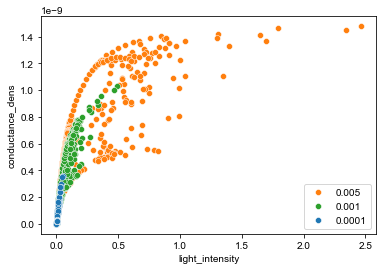

In [57]:
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.005],
    x='light_intensity', y='conductance_dens',color='tab:orange', label='0.005'
)
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.001],
    x='light_intensity', y='conductance_dens',color='tab:green', label='0.001'
)
sns.scatterplot(
    data=c_le_stimpositionavrg.loc[0.0001],
    x='light_intensity', y='conductance_dens',color='tab:blue', label='0.0001',
)
plt.show()

In [28]:
c_le_angle_avrg = cond_light_energy_merged.groupby(['light_power','seg','radius'])['light_energy', 'conductance', 'APC'].mean()
c_le_angle_avrg['seglabel'] = [compartment_converter(seg) for seg in c_le_angle_avrg.reset_index().seg]
c_le_angle_avrg
cond_light_energy_merged['seglabel'] = [compartment_converter(seg) for seg in cond_light_energy_merged.reset_index().seg]
cond_light_energy_merged = cond_light_energy_merged.set_index(['light_power','seg','radius'])

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


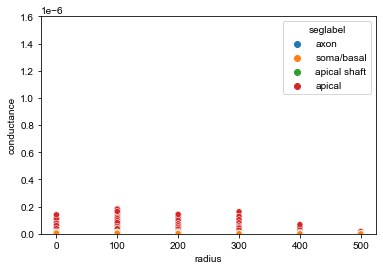

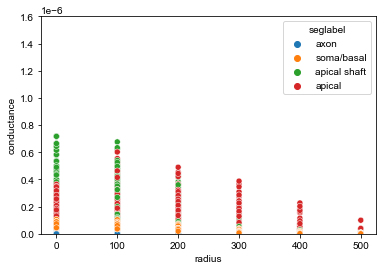

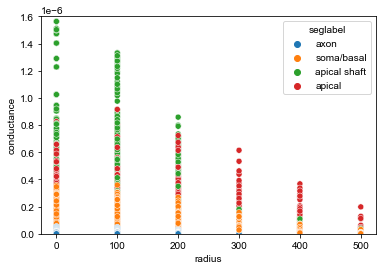

In [33]:
for lp in light_powers:
    sns.scatterplot(
        data=cond_light_energy_merged.loc[lp],
        x='radius', y='conductance',hue='seglabel', palette='tab10',
    )
    plt.ylim(0,1.6e-6)
    plt.show()

In [49]:
max_c_APC_angle_avrg = c_le_angle_avrg.groupby(['light_power','radius'])['conductance', 'APC'].max()

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


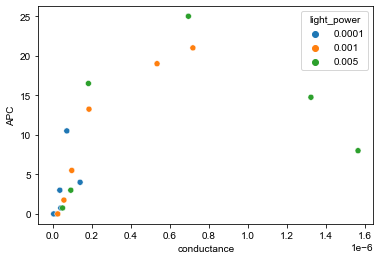

In [50]:
sns.scatterplot(
    data=max_c_APC_angle_avrg,
    x='conductance', y='APC', hue='light_power', palette='tab10'
)
plt.show()

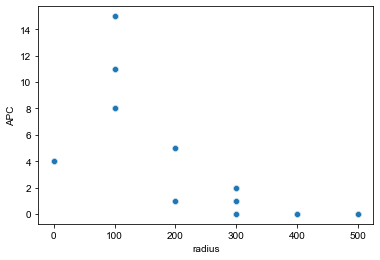

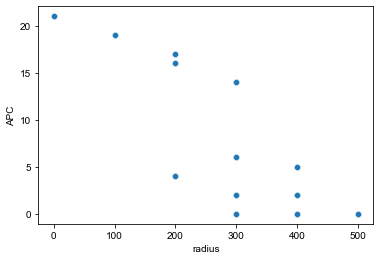

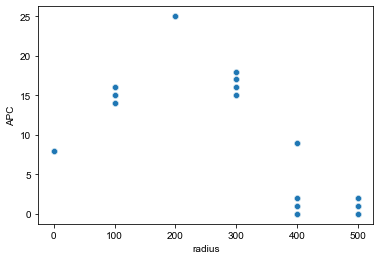

In [47]:
for lp in light_powers:
    sns.scatterplot(
        data=cond_light_energy_merged.loc[lp],
        x='radius', y='APC',
    )
    plt.show()

In [31]:
cond_light_energy_merged.loc[0.02]

KeyError: 0.02

In [ ]:
radius = 0
angle = 0
light_power = 0.02
measurement = stimulate_and_measure(radius, angle, light_power, rec_vars=[segcatpointernames,segcatpointers])

In [ ]:
measurement

In [ ]:
plt.plot(measurement['time [ms]'], measurement['V_soma(0.5)'])
for time in get_AP_times(measurement, interpol_dt=0.1, AP_threshold=0, t_on=light_delay):
    plt.axvline(x=time, c='red')